### Importa Bibliotecas

In [30]:
# Bibliotecas principais e gerenciamento de dados
import pandas as pd
import numpy as np
import pickle
import time
import itertools
from itertools import combinations
from itertools import product

# Modelos e métricas de machine learning e estatística
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import jarque_bera
import statsmodels.api as sm

# Visualização de dados
import matplotlib.pyplot as plt
import seaborn as sns

# Barra de progresso
from tqdm import tqdm

# Gerenciamento de avisos
import warnings
warnings.filterwarnings("ignore")  # Ignora avisos para manter o output limpo

### Funções

In [31]:
# Função para realizar o teste ADF e verificar estacionariedade
def adf_test(series, name):
    result = adfuller(series, autolag='AIC')
    print(f'\nTeste ADF para {name}:')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value:.3f}')

    # Avaliar se a série é estacionária com base no p-valor
    if result[1] < 0.05:
        print("Resultado: A série é estacionária.")
        return True  # Retorna True se a série for estacionária
    else:
        print("Resultado: A série é não estacionária.")
        return False  # Retorna False se a série for não estacionária

In [32]:
def find_best_var_model(df_train, target_variable, max_comb_size=None, maxlags=None):
    variables = [col for col in df_train.columns if col != target_variable]
    if max_comb_size is None:
        max_comb_size = len(variables)

    best_rmse = np.inf
    best_combination = None
    best_lag = None

    for r in range(1, max_comb_size + 1):
        for comb in combinations(variables, r):
            comb = list(comb) + [target_variable]
            df_subset = df_train[comb].dropna()

            # certifica que o valor de maxlags não exceda o número de observações
            if maxlags is None or maxlags > len(df_subset) / (len(comb) * 10):  
                maxlags = len(df_subset) // (len(comb) * 10)  

            if maxlags < 1:
                continue  # dados insuficientes para ajustar o modelo

            model = VAR(df_subset)
            results = model.fit(maxlags=maxlags, ic='aic')
            lag = results.k_ar
            forecast = results.forecast(df_subset.values[-lag:], steps=1)
            actual = df_subset.iloc[-1][target_variable]
            rmse = np.sqrt(mean_squared_error([actual], [forecast[0][-1]]))

            if rmse < best_rmse:
                best_rmse = rmse
                best_combination = comb[:-1]  # remover a variável alvo da melhor combinação
                best_lag = lag

    return best_combination, best_rmse, best_lag

In [33]:
# Função para calcular MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

### Parâmetros

In [34]:
data_inicial = '20180101'
data_final = '20231201'

# define target
target = 'PD'

### Importa Bases

In [35]:
# Carregar e preparar os dados
df = pd.read_parquet('base.parquet')

### Tratamento Base

In [36]:
# corte temporal
df = df[df['DATA_REFERENCIA'] >= data_inicial]
df = df[df['DATA_REFERENCIA'] <= data_final]

# definindo índice
df.set_index('DATA_REFERENCIA', inplace=True)


# Verificar as primeiras linhas
df.head()

,PD,IPCA_LAG_1,IPCA_LAG_3,IPCA_LAG_6,IPCA_LAG_12,DESEMPREGO_LAG_1,DESEMPREGO_LAG_3,DESEMPREGO_LAG_6,DESEMPREGO_LAG_12,PIB_LAG_1,...,PIB_LAG_6,PIB_LAG_12,SELIC_LAG_1,SELIC_LAG_3,SELIC_LAG_6,SELIC_LAG_12,CAMBIO_LAG_1,CAMBIO_LAG_3,CAMBIO_LAG_6,CAMBIO_LAG_12
DATA_REFERENCIA,,,,,,,,,,,,,,,,,,,,,
2018-01-01,3.861777,5.410274,5.159236,2.918972,4.657135,11.9,12.3,12.9,12.7,588892.8,...,557458.2,526564.7,6.675963,7.956187,10.033869,13.893348,3.291915,3.191229,3.206138,3.196609
2018-02-01,3.798198,3.536617,3.412864,2.303129,4.032747,12.3,12.1,12.7,13.3,555644.6,...,555578.7,514120.5,7.186373,7.058561,10.033869,10.954329,3.210609,3.259380,3.150917,3.104194
2018-03-01,3.815173,3.908738,5.410274,1.935750,3.040525,12.7,11.9,12.5,13.9,528905.5,...,528871.2,544312.9,5.788102,6.675963,7.956187,13.353730,3.241500,3.291915,3.134790,3.127930
2018-04-01,3.823845,1.084909,3.536617,5.159236,1.692904,13.2,12.3,12.3,13.7,560120.7,...,549304.7,525238.1,6.548709,7.186373,7.956187,9.902948,3.279214,3.210609,3.191229,3.136172
2018-05-01,3.876315,2.671660,3.908738,3.412864,3.784558,13.0,12.7,12.1,13.4,559359.8,...,566209.3,548887.7,6.421594,5.788102,7.058561,11.748906,3.407495,3.241500,3.259380,3.209509


### Teste Estacionariedade ADF

Todas as séries precisam ser estacionárias até a primeira diferença.

In [37]:
stationary_series = {}  # Dicionário para guardar as séries estacionárias

# Teste de estacionariedade no nível para cada coluna
print("Teste de Estacionariedade no Nível:")
for column in df.columns:
    if adf_test(df[column], f"Nível: {column}"):
        stationary_series[column] = df[column]  # Adiciona a série se for estacionária no nível

Teste de Estacionariedade no Nível:

Teste ADF para Nível: PD:
ADF Statistic: -3.198954
p-value: 0.020045
Critical Values:
	1%: -3.527
	5%: -2.904
	10%: -2.589
Resultado: A série é estacionária.

Teste ADF para Nível: IPCA_LAG_1:
ADF Statistic: -4.596299
p-value: 0.000131
Critical Values:
	1%: -3.526
	5%: -2.903
	10%: -2.589
Resultado: A série é estacionária.

Teste ADF para Nível: IPCA_LAG_3:
ADF Statistic: -4.614091
p-value: 0.000122
Critical Values:
	1%: -3.526
	5%: -2.903
	10%: -2.589
Resultado: A série é estacionária.

Teste ADF para Nível: IPCA_LAG_6:
ADF Statistic: -4.581514
p-value: 0.000140
Critical Values:
	1%: -3.526
	5%: -2.903
	10%: -2.589
Resultado: A série é estacionária.

Teste ADF para Nível: IPCA_LAG_12:
ADF Statistic: -4.649092
p-value: 0.000105
Critical Values:
	1%: -3.526
	5%: -2.903
	10%: -2.589
Resultado: A série é estacionária.

Teste ADF para Nível: DESEMPREGO_LAG_1:
ADF Statistic: -1.617219
p-value: 0.474188
Critical Values:
	1%: -3.542
	5%: -2.910
	10%: -2.59

In [38]:
# Teste de estacionariedade na primeira diferença
print("\nTeste de Estacionariedade na Primeira Diferença:")
df_diff = df.diff().dropna()  # Calculando a primeira diferença e removendo NA
for column in df_diff.columns:
    if column not in stationary_series:  # Testa somente se a série não foi estacionária no nível
        if adf_test(df_diff[column], f"Primeira Diferença: {column}"):
            stationary_series[f'DIFF_{column}'] = df_diff[column]  # Adiciona a série diferenciada com prefixo


Teste de Estacionariedade na Primeira Diferença:

Teste ADF para Primeira Diferença: DESEMPREGO_LAG_1:
ADF Statistic: -2.687467
p-value: 0.076232
Critical Values:
	1%: -3.532
	5%: -2.906
	10%: -2.590
Resultado: A série é não estacionária.

Teste ADF para Primeira Diferença: DESEMPREGO_LAG_3:
ADF Statistic: -2.047929
p-value: 0.265961
Critical Values:
	1%: -3.548
	5%: -2.913
	10%: -2.594
Resultado: A série é não estacionária.

Teste ADF para Primeira Diferença: DESEMPREGO_LAG_6:
ADF Statistic: -2.071482
p-value: 0.256136
Critical Values:
	1%: -3.548
	5%: -2.913
	10%: -2.594
Resultado: A série é não estacionária.

Teste ADF para Primeira Diferença: PIB_LAG_1:
ADF Statistic: -1.916272
p-value: 0.324446
Critical Values:
	1%: -3.546
	5%: -2.912
	10%: -2.594
Resultado: A série é não estacionária.

Teste ADF para Primeira Diferença: PIB_LAG_3:
ADF Statistic: -1.759825
p-value: 0.400582
Critical Values:
	1%: -3.546
	5%: -2.912
	10%: -2.594
Resultado: A série é não estacionária.

Teste ADF par

In [39]:
# Criar um novo DataFrame somente com as séries estacionárias (em nível ou em primeira diferença)
df_estacionario = pd.DataFrame(stationary_series)

df_estacionario

,PD,IPCA_LAG_1,IPCA_LAG_3,IPCA_LAG_6,IPCA_LAG_12,DESEMPREGO_LAG_12,DIFF_SELIC_LAG_12,DIFF_CAMBIO_LAG_1,DIFF_CAMBIO_LAG_3,DIFF_CAMBIO_LAG_6,DIFF_CAMBIO_LAG_12
DATA_REFERENCIA,,,,,,,,,,,
2018-01-01,3.861777,5.410274,5.159236,2.918972,4.657135,12.7,NaN,NaN,NaN,NaN,NaN
2018-02-01,3.798198,3.536617,3.412864,2.303129,4.032747,13.3,-2.939019,-0.081306,0.068151,-0.055221,-0.092415
2018-03-01,3.815173,3.908738,5.410274,1.935750,3.040525,13.9,2.399401,0.030891,0.032535,-0.016127,0.023736
2018-04-01,3.823845,1.084909,3.536617,5.159236,1.692904,13.7,-3.450782,0.037714,-0.081306,0.056439,0.008242
2018-05-01,3.876315,2.671660,3.908738,3.412864,3.784558,13.4,1.845958,0.128281,0.030891,0.068151,0.073337
...,...,...,...,...,...,...,...,...,...,...,...
2023-08-01,3.207965,1.449188,2.794262,10.558872,-4.234939,8.9,1.894854,-0.050800,-0.036900,-0.029000,-0.224800
2023-09-01,3.235853,2.795873,-0.955390,8.861143,-3.425441,8.7,-1.356410,0.102700,-0.131200,0.039800,0.093700
2023-10-01,3.238519,3.165646,1.449188,7.570845,7.315329,8.3,-0.672690,0.033500,-0.050800,-0.191800,0.013300


In [40]:
# remover nulo originado pela primeira diferença
df_estacionario.dropna(inplace=True)

### Multicolinearidade

A multicolinearidade não é um problema em modelos de Vetores Autorregressivos (VAR).

**Natureza do Modelo VAR:**

O VAR modela todas as variáveis endógenas como função das defasagens delas mesmas e das outras variáveis endógenas. Ele não tenta separar "causas" e "efeitos" da mesma maneira que modelos como regressão linear ou SARIMAX.

A relação entre as variáveis no VAR é interpretada de forma conjunta, então a multicolinearidade nas variáveis não inviabiliza o modelo.

**Multicolinearidade e Estimativa de Parâmetros:**

Em um contexto VAR, mesmo que as variáveis sejam altamente correlacionadas, o modelo consegue estimar os coeficientes utilizando os métodos apropriados (como Mínimos Quadrados Ordinários ou Generalizados) para cada equação do sistema.

**Impacto da Multicolinearidade em VAR:**

Embora a multicolinearidade não impeça a estimativa dos coeficientes, ela pode dificultar a interpretação isolada de coeficientes individuais. Porém, isso geralmente não é o foco em modelos VAR, que são usados principalmente para análises de interdependência dinâmica e previsões.

### O que é importante no VAR?

**Estacionariedade:**

Todas as séries devem ser estacionárias (ou cointegradas, se você estiver usando um VECM). Isso é fundamental para evitar resultados espúrios.

**Definição da Ordem do Modelo (lags):**

A seleção do número adequado de defasagens (p) é crucial. Critérios como AIC, BIC ou HQ são usados para determinar isso.

**Interpretação Baseada em Dinâmica:**

No VAR, o foco é geralmente em funções de resposta ao impulso (IRFs), decomposição de variância e previsões, e não na análise isolada dos coeficientes.

### Separação Treino/Teste

In [41]:
# Separar em treino e teste
train_size = int(len(df_estacionario) * 0.8)  
df_train = df_estacionario.iloc[:train_size]
len(df_train)

56

In [42]:
test_size = len(df_estacionario) - train_size
df_test = df_estacionario.iloc[train_size:]
len(df_test)

15

### Modelo VAR

Aqui, utilizamos uma função para trazer os parâmetros do melhor lag e combinação de variáveis (em relação à 'PD' que minimizam o RMSE):

In [43]:
best_combination_var, best_rmse_var, best_lag_var = find_best_var_model(df_train, target, max_comb_size=len(df_train.columns) - 1)
print(f"Best combination: {best_combination_var}, Best RMSE: {best_rmse_var}, Best lag: {best_lag_var}") 

Best combination: ['DESEMPREGO_LAG_12', 'DIFF_CAMBIO_LAG_1', 'DIFF_CAMBIO_LAG_3'], Best RMSE: 4.768733280391402e-05, Best lag: 1


### Treinamento do Modelo VAR

Com os parâmetros definidos anterioremente, treinamos o VAR:

In [44]:
model_var = VAR(df_train[best_combination_var + [target]].dropna())
fitted_model_var = model_var.fit(best_lag_var)
print(fitted_model_var.summary()) 

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 11, Jan, 2025
Time:                     10:25:16
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   -12.1010
Nobs:                     55.0000    HQIC:                  -12.5487
Log likelihood:           60.6840    FPE:                2.68209e-06
AIC:                     -12.8309    Det(Omega_mle):     1.89374e-06
--------------------------------------------------------------------
Results for equation DESEMPREGO_LAG_12
                          coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------
const                        1.785645         0.822848            2.170           0.030
L1.DESEMPREGO_LAG_12         0.943795         0.042732           22.087           0.000
L1.DIFF_CAMBIO_LAG_1

### Análise dos Resíduos



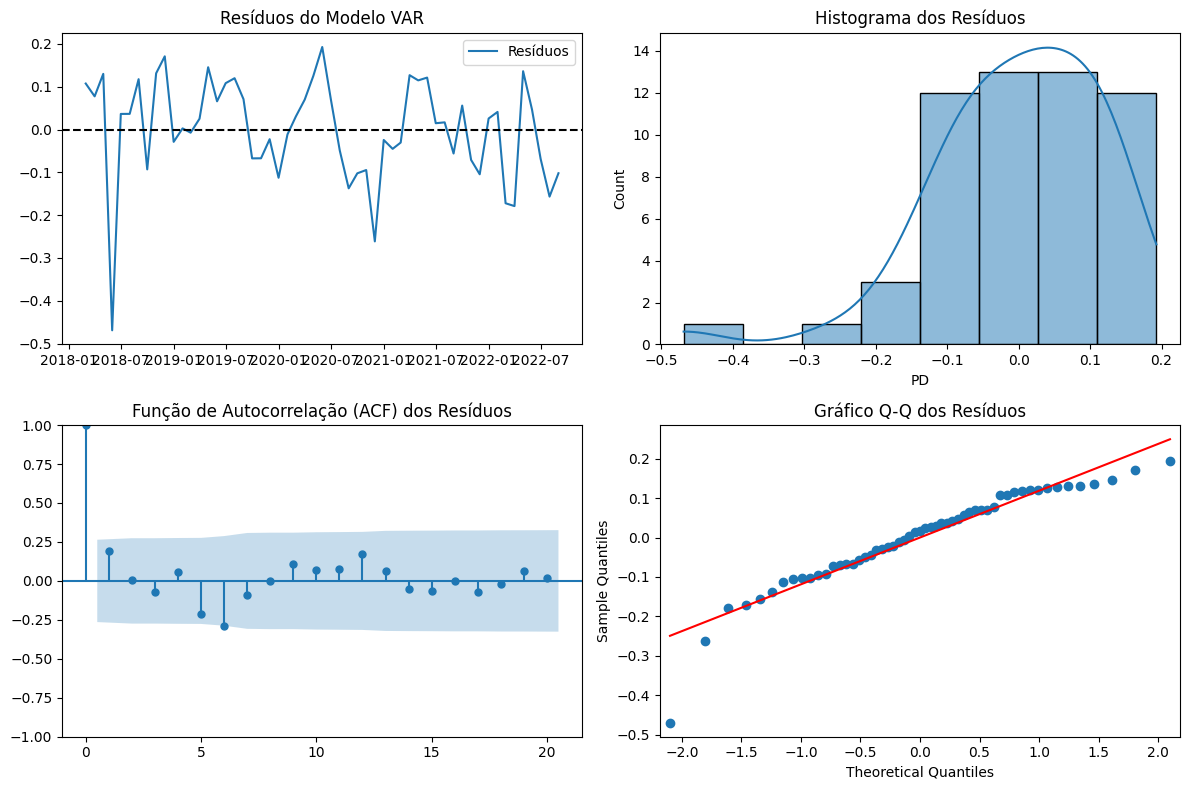


Interpretação dos Resultados:

1. Teste de Jarque-Bera:
   - Estatística: 29.4849
   - p-valor: 0.0000
   Os resíduos não seguem uma distribuição normal.

2. Teste de Ljung-Box (lag 10):
   - Estatística: 12.7645
   - p-valor: 0.2371
   Não há autocorrelação significativa nos resíduos.




In [45]:
# Pegando os resíduos do modelo VAR
residuos = fitted_model_var.resid[target]  # Chamar o método resid()

# Ajustando o erro no teste Jarque-Bera 
jb_stat, jb_pvalue = jarque_bera(residuos)

# Teste Ljung-Box
ljung_box_test = acorr_ljungbox(residuos, lags=[10], return_df=True)

# Criando os gráficos
plt.figure(figsize=(12, 8))

# Gráfico de resíduos
plt.subplot(2, 2, 1)
plt.plot(residuos, label='Resíduos')
plt.axhline(0, color='black', linestyle='--')
plt.title('Resíduos do Modelo VAR')
plt.legend()

# Histograma dos resíduos
plt.subplot(2, 2, 2)
sns.histplot(residuos, kde=True)
plt.title('Histograma dos Resíduos')

# ACF dos resíduos
plt.subplot(2, 2, 3)
sm.graphics.tsa.plot_acf(residuos, ax=plt.gca(), lags=20)
plt.title('Função de Autocorrelação (ACF) dos Resíduos')

# Q-Q plot
plt.subplot(2, 2, 4)
sm.qqplot(residuos, line='s', ax=plt.gca())
plt.title('Gráfico Q-Q dos Resíduos')

plt.tight_layout()
plt.show()

# Interpretando os resultados
interpretation = f"""
Interpretação dos Resultados:

1. Teste de Jarque-Bera:
   - Estatística: {jb_stat:.4f}
   - p-valor: {jb_pvalue:.4f}
   {'Os resíduos seguem uma distribuição normal.' if jb_pvalue > 0.05 else 'Os resíduos não seguem uma distribuição normal.'}

2. Teste de Ljung-Box (lag 10):
   - Estatística: {ljung_box_test['lb_stat'].values[0]:.4f}
   - p-valor: {ljung_box_test['lb_pvalue'].values[0]:.4f}
   {'Não há autocorrelação significativa nos resíduos.' if ljung_box_test['lb_pvalue'].values[0] > 0.05 else 'Há autocorrelação significativa nos resíduos.'}

"""

print(interpretation)

### Previsão e Avaliação do Modelo

In [27]:
# Obter os valores reais e as previsões ajustadas no conjunto de treino
y_true_train = df_train[best_combination_var + [target]].iloc[best_lag_var:]  # Ignora os primeiros valores, pois o modelo precisa de lags iniciais
y_pred_train = fitted_model_var.fittedvalues

# Previsões out-of-sample para o conjunto de teste
y_true_test = df_test[best_combination_var + [target]]
y_pred_test = pd.DataFrame(fitted_model_var.forecast(df_train[best_combination_var + [target]].values[-best_lag_var:], steps=len(df_test)), index=df_test.index, columns=best_combination_var + [target])

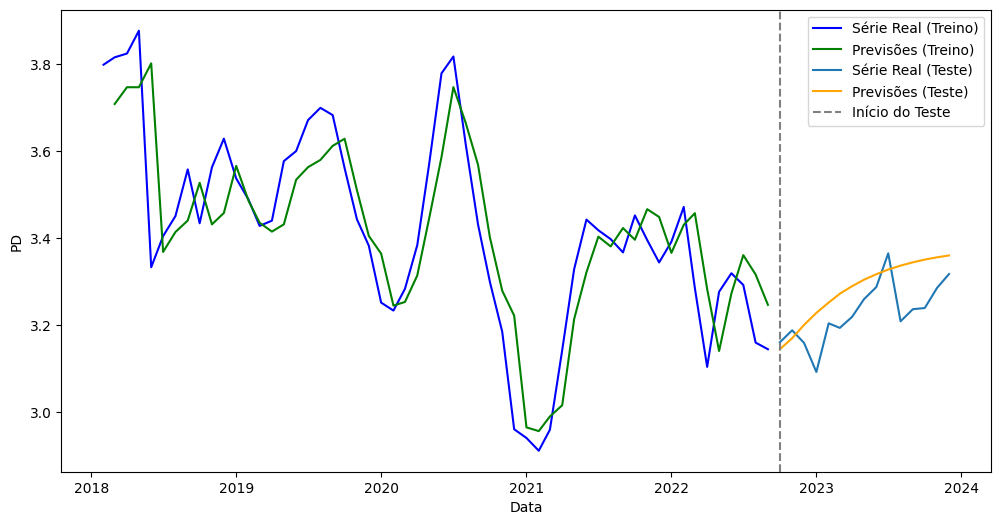

In [28]:
# Visualizar as previsões
plt.figure(figsize=(12, 6))

# Plot da série real do treino
plt.plot(df_train.index, df_train[target], label='Série Real (Treino)', color='blue')
# Previsões do treino
plt.plot(y_pred_train.index, y_pred_train[target], label='Previsões (Treino)', color='green')

# Plot da série real do teste
plt.plot(df_test.index, df_test[target], label='Série Real (Teste)')
# Previsões do teste
plt.plot(y_pred_test.index, y_pred_test[target], label='Previsões (Teste)', color='orange')

plt.axvline(x=df_test.index[0], color='gray', linestyle='--', label='Início do Teste')
plt.xlabel('Data')
plt.ylabel(target)
plt.legend()
plt.show()

### R2 Modelo

In [29]:
from sklearn.metrics import r2_score

r2_scores = {}
n = len(y_true_train)  # Número de observações
k = len(y_true_train.columns) - 1  # Número de variáveis explicativas

for column in y_true_train.columns:
    r2 = r2_score(y_true_train[column], y_pred_train[column])
    r2_adjusted = 1 - ((1 - r2) * (n - 1)) / (n - k - 1)
    r2_scores[column] = {'R2': r2, 'R2_ajustado': r2_adjusted}

# Exibir os resultados
for variable, scores in r2_scores.items():
    print(f"{variable}: R² = {scores['R2']:.4f}, R² ajustado = {scores['R2_ajustado']:.4f}")

DESEMPREGO_LAG_12: R² = 0.9171, R² ajustado = 0.9123
DIFF_CAMBIO_LAG_1: R² = 0.0654, R² ajustado = 0.0104
DIFF_CAMBIO_LAG_3: R² = 0.1239, R² ajustado = 0.0724
PD: R² = 0.7187, R² ajustado = 0.7022


### Métricas do Modelo

In [20]:
# Inicializar dicionários para armazenar as métricas
metrics_train = {}
metrics_test = {}

# Calcular as métricas para cada variável no conjunto de treino
for column in y_true_train.columns:
    rmse_train = np.sqrt(mean_squared_error(y_true_train[column], y_pred_train[column]))
    mae_train = mean_absolute_error(y_true_train[column], y_pred_train[column])
    mape_train = mean_absolute_percentage_error(y_true_train[column], y_pred_train[column])
    
    metrics_train[column] = {'RMSE': rmse_train, 'MAE': mae_train, 'MAPE': mape_train}

# Calcular as métricas para cada variável no conjunto de teste
for column in y_true_test.columns:
    rmse_test = np.sqrt(mean_squared_error(y_true_test[column], y_pred_test[column]))
    mae_test = mean_absolute_error(y_true_test[column], y_pred_test[column])
    mape_test = mean_absolute_percentage_error(y_true_test[column], y_pred_test[column])
    
    metrics_test[column] = {'RMSE': rmse_test, 'MAE': mae_test, 'MAPE': mape_test}

# Exibir as métricas
print("\nMétricas para o conjunto de treino:")
for variable, metrics in metrics_train.items():
    print(f"{variable} - RMSE: {metrics['RMSE']:.4f}, MAE: {metrics['MAE']:.4f}, MAPE: {metrics['MAPE']:.2f}%")

print("\nMétricas para o conjunto de teste:")
for variable, metrics in metrics_test.items():
    print(f"{variable} - RMSE: {metrics['RMSE']:.4f}, MAE: {metrics['MAE']:.4f}, MAPE: {metrics['MAPE']:.2f}%")



Métricas para o conjunto de treino:
DESEMPREGO_LAG_12 - RMSE: 0.3014, MAE: 0.2443, MAPE: 1.88%
DIFF_CAMBIO_LAG_1 - RMSE: 0.1923, MAE: 0.1531, MAPE: 102.09%
DIFF_CAMBIO_LAG_3 - RMSE: 0.1803, MAE: 0.1371, MAPE: 93.58%
PD - RMSE: 0.1186, MAE: 0.0922, MAPE: 2.72%

Métricas para o conjunto de teste:
DESEMPREGO_LAG_12 - RMSE: 3.5400, MAE: 3.2248, MAPE: 35.17%
DIFF_CAMBIO_LAG_1 - RMSE: 0.1044, MAE: 0.0808, MAPE: 102.93%
DIFF_CAMBIO_LAG_3 - RMSE: 0.1306, MAE: 0.0935, MAPE: 102.29%
PD - RMSE: 0.0756, MAE: 0.0653, MAPE: 2.03%


### Salvando Modelo

In [21]:
# Nome do arquivo onde o modelo será salvo
model_filename = 'modelo_var_completo.pkl'

# Salvando o modelo em um arquivo pickle
with open(model_filename, 'wb') as file:
    pickle.dump(model_var, file)

print(f"Modelo salvo em: {model_filename}")

Modelo salvo em: modelo_var_completo.pkl
